Installation af libraries

In [1]:
!pip install geopandas
!pip install pandas
!pip install rasterio
!pip install rasterstats
!pip install owslib
!pip install matplotlib


Indlæsning af libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
from rasterstats import zonal_stats
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable


Indlæsning af data

<Axes: >

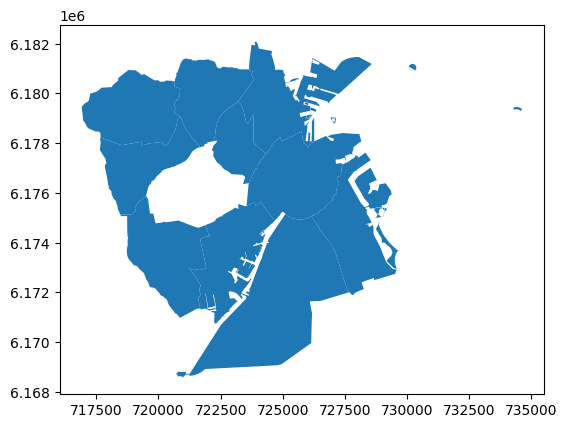

In [34]:
inputuhi = r"/content/sample_data/lst_nykoebing_f_2025_celcius.tif"
uhiraster = rasterio.open(inputuhi).read(1).astype(float)

uhiraster[uhiraster < 0] = np.nan 

url = "/content/sample_data/nykoebing_afstemningsomraader.gpkg"

admin_gr_gdf = gpd.read_file(url)
admin_gr_gdf.set_crs(epsg=2582, inplace=True,allow_override=True)
admin_gr_gdf.plot()

Simpelt plot

Text(0.5, 1.0, 'Raw uhi')

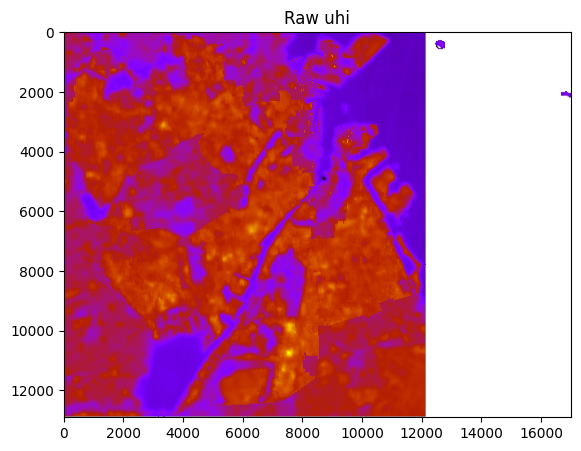

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))

chm_plot = ax.imshow(uhiraster, cmap='YlOrRd' )

ax.set_title("Raw uhi")

Zonal statistics

In [35]:
zs_uhi_adminomraader = zonal_stats(admin_gr_gdf, inputuhi, stats='mean',geojson_out=True)
gdf_uhi_adminomraader =  gpd.GeoDataFrame.from_features(zs_uhi_adminomraader)

Plot gennemsnitsværdier inden for grænser

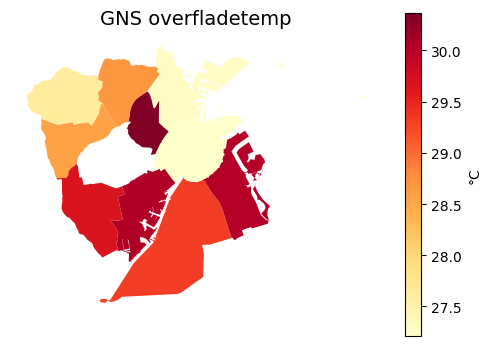

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# cmap = 'YlOrRd'
fig = gdf_uhi_adminomraader.plot(
    column='mean',
    cmap='YlOrRd',
    linewidth=0.5,
    legend= True,
    ax=ax,
    legend_kwds={'label': "°C", 'shrink': 0.7}
    )
ax.set_title("GNS overfladetemp", fontsize=14)
ax.axis('off')
plt.show()


Indeksering

Text(0.5, 1.0, 'Reclassed uhi')

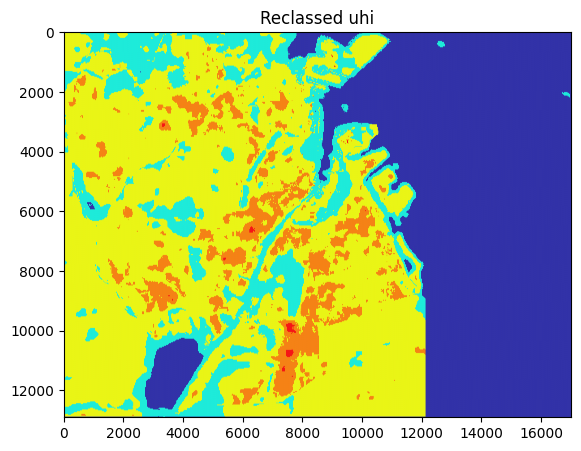

In [3]:
# reclassifier UHI
valid_mask = ~np.isnan(uhiraster)
valid_values = uhiraster[valid_mask]

# Define class bins
n_classes = 5
bins = np.linspace(np.nanmin(uhiraster), np.nanmax(uhiraster), n_classes + 1)

# Digitize only the valid values
reclassified_uhi = np.zeros_like(uhiraster, dtype=int)  # initialize output
reclassified_uhi[valid_mask] = np.digitize(valid_values, bins, right=False)

# Define the colors you want
cmap = ListedColormap(["#3232a8", "#1eebda", "#eaf516", "#f58216","#f51616"])

# Define a normalization from values -> colors
norm = colors.BoundaryNorm([1, 2, 3, 4,5], 5)

fig, ax = plt.subplots(figsize=(10, 5))

chm_plot = ax.imshow(reclassified_uhi,
                     cmap=cmap )

ax.set_title("Reclassed uhi")
